In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
pd.options.display.float_format = '{:.4f}'.format

In [2]:
df = pd.read_csv('Customers.csv', delimiter = ';')
df

,CustomerId,Profit,Recency,Frequency,Monetary,Variance
0,1,187,63,1,"2349,06",2
1,2,96,10,6,"922,62",4
2,3,47,35,4,"881,22",3
3,4,294,5,1,"3815,16",2
4,5,732,4,31,"41868,11",29
...,...,...,...,...,...,...
1506,1507,174,18,3,"15798,92",17
1507,1508,124,28,12,"2676,89",7
1508,1509,1543,4,17,"109497,54",54
1509,1510,668,1,3,"49602,45",17


In [3]:
df['Monetary'] = df['Monetary'].str.replace(',', '.')

## Zamiana kolumn na Float

In [4]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], downcast='float')

## Usuwanie outlinerów za pomocą zScore

In [5]:
zScore = np.abs(scipy.stats.zscore(df))

In [6]:
threshold = 3
df_bezOutlier = df[(zScore<threshold).all(axis=1)].reset_index()
df_bezOutlier

,index,CustomerId,Profit,Recency,Frequency,Monetary,Variance
0,0,1.0000,187.0000,63.0000,1.0000,2349.0601,2.0000
1,1,2.0000,96.0000,10.0000,6.0000,922.6200,4.0000
2,2,3.0000,47.0000,35.0000,4.0000,881.2200,3.0000
3,3,4.0000,294.0000,5.0000,1.0000,3815.1599,2.0000
4,4,5.0000,732.0000,4.0000,31.0000,41868.1094,29.0000
...,...,...,...,...,...,...,...
1431,1506,1507.0000,174.0000,18.0000,3.0000,15798.9199,17.0000
1432,1507,1508.0000,124.0000,28.0000,12.0000,2676.8899,7.0000
1433,1508,1509.0000,1543.0000,4.0000,17.0000,109497.5391,54.0000
1434,1509,1510.0000,668.0000,1.0000,3.0000,49602.4492,17.0000


C:\ANACONDA\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ANACONDA\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ANACONDA\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

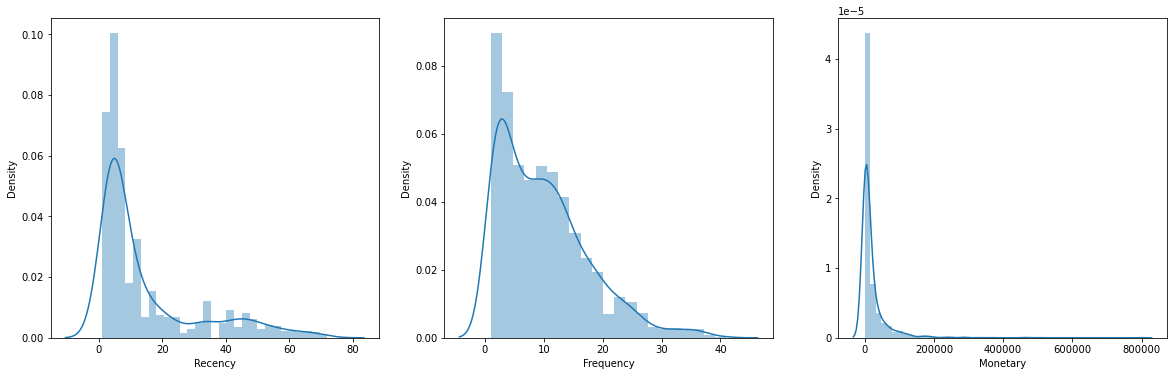

In [7]:
plt.figure(figsize=(20,20))
plt.subplot(3, 3, 1)
sns.distplot(df_bezOutlier['Recency'], norm_hist=False)
plt.subplot(3, 3, 2)
sns.distplot(df_bezOutlier['Frequency'], norm_hist=False)
plt.subplot(3, 3, 3)
sns.distplot(df_bezOutlier['Monetary'], norm_hist=False)

In [8]:
df_bezOutlier.describe([.20, .40, .60, .80])

,index,CustomerId,Profit,Recency,Frequency,Monetary,Variance
count,1436.0000,1436.0000,1436.0000,1436.0000,1436.0000,1436.0000,1436.0000
mean,750.3231,751.3231,470.3419,14.5139,9.9394,21444.4492,15.3593
std,434.8388,434.8389,865.8509,16.4108,7.6197,47145.1016,13.7384
min,0.0000,1.0000,1.0000,1.0000,1.0000,7.2900,1.0000
20%,298.0000,299.0000,62.0000,4.0000,3.0000,1058.8800,4.0000
40%,598.0000,599.0000,155.0000,5.0000,6.0000,3528.7200,8.0000
50%,749.5000,750.5000,219.5000,6.0000,9.0000,5674.1501,11.0000
60%,898.0000,899.0000,304.0000,10.0000,11.0000,9282.3301,14.0000
80%,1200.0000,1201.0000,653.0000,24.0000,16.0000,28018.5391,25.0000
max,1510.0000,1511.0000,14724.0000,72.0000,41.0000,795810.9375,69.0000


 ## Ręczny przydział RFM-score oraz RFM-Group
 segmentacja z użyciem uczenia nienadzorowanego dalej

In [9]:
r_bins=[-1, 4, 5, 10, 24, 72]
f_bins=[0, 3, 6, 11, 16, 41]
m_bins=[0, 1058, 3528, 9282, 28018, 795810]
df_bezOutlier['r_score'] = pd.to_numeric(pd.cut(df_bezOutlier['Recency'], r_bins, labels = [5, 4, 3, 2, 1]), downcast='integer')
df_bezOutlier['f_score'] =  pd.to_numeric(pd.cut(df_bezOutlier['Frequency'], f_bins, labels = [1, 2, 3, 4, 5]), downcast='integer')
df_bezOutlier['m_score'] =  pd.to_numeric(pd.cut(df_bezOutlier['Monetary'], m_bins, labels = [1, 2, 3, 4, 5]), downcast='integer')
df_bezOutlier = df_bezOutlier.dropna().reset_index()
df_bezOutlier = df_bezOutlier.astype({'r_score': int, 'f_score': int, 'm_score': int})
df_bezOutlier

,level_0,index,CustomerId,Profit,Recency,Frequency,Monetary,Variance,r_score,f_score,m_score
0,0,0,1.0000,187.0000,63.0000,1.0000,2349.0601,2.0000,1,1,2
1,1,1,2.0000,96.0000,10.0000,6.0000,922.6200,4.0000,3,2,1
2,2,2,3.0000,47.0000,35.0000,4.0000,881.2200,3.0000,1,2,1
3,3,3,4.0000,294.0000,5.0000,1.0000,3815.1599,2.0000,4,1,3
4,4,4,5.0000,732.0000,4.0000,31.0000,41868.1094,29.0000,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...
1430,1431,1506,1507.0000,174.0000,18.0000,3.0000,15798.9199,17.0000,2,1,4
1431,1432,1507,1508.0000,124.0000,28.0000,12.0000,2676.8899,7.0000,1,4,2
1432,1433,1508,1509.0000,1543.0000,4.0000,17.0000,109497.5391,54.0000,5,5,5
1433,1434,1509,1510.0000,668.0000,1.0000,3.0000,49602.4492,17.0000,5,1,5


## Przydział nazw poszczególnych grub na bazie udostępnionego linku
w przypadkach w których na bazie tabeli podanej w linku nie można bylo przydzielić klienta do określonej grupy, przydzielany zostaje do grupy 'Uncertain'

In [10]:
df_bezOutlier['RFM_group'] = df_bezOutlier['r_score'].map(str)+df_bezOutlier['f_score'].map(str)+df_bezOutlier['m_score'].map(str)
df_bezOutlier['RFM_group_name'] = np.NaN
df_bezOutlier['RFM_group_name'] = df_bezOutlier.apply(lambda x: 'Champion' if (x['r_score'] >=4) and (x['f_score'] >=4) and (x['m_score'] >=4) else
                                                      
                                                      'Loyal Custome' if (x['r_score'] >=2) and (x['f_score'] >=3) and (x['m_score'] >=3) else
                                                      
                                                      'Potential Loyalist' if (x['r_score'] >=3) and (x['f_score'] >=1 and x['f_score'] <=3 ) and (x['m_score'] >=1 and x['m_score'] <=3) else
                                                      
                                                      'New Customer' if (x['r_score'] >=4) and (x['f_score'] <=1) and (x['m_score'] <=1) else
                                                      
                                                      'Promising' if (x['r_score'] >=3 and x['r_score'] <=4) and (x['f_score'] <=1) and (x['m_score'] <=1) else
                                                      
                                                      'Needs Attention' if (x['r_score'] >=2 and x['r_score'] <=3) and (x['f_score'] >=2 and x['f_score'] <=3) and (x['m_score'] >=2 and x['m_score'] <=3) else
                                                      
                                                      'About To Sleep' if (x['r_score'] >=2 and x['r_score'] <=3) and (x['f_score'] <=2) and (x['m_score'] <=2) else
                                                      
                                                      'At Risk' if (x['r_score'] <=2) and (x['f_score'] >=2) and (x['m_score'] >=2) else
                                                      
                                                      'Can’t Lose Them' if (x['r_score'] <=1) and (x['f_score'] >=4) and (x['m_score'] >=4) else
                                                      
                                                      'Hibernating' if (x['r_score'] >=1 and x['r_score'] <=2) and (x['f_score'] >=1 and x['f_score'] <=2) and (x['m_score'] >=1 and x['m_score'] <=3) else
                                                      
                                                      'Lost' if (x['r_score'] <= 2) and (x['f_score'] <= 2) and (x['m_score'] <= 2) else 'Uncertain',
                                          axis = 1)
df_bezOutlier['RFM_score'] = df_bezOutlier['r_score']+df_bezOutlier['f_score']+df_bezOutlier['m_score']

df_bezOutlier

,level_0,index,CustomerId,Profit,Recency,Frequency,Monetary,Variance,r_score,f_score,m_score,RFM_group,RFM_group_name,RFM_score
0,0,0,1.0000,187.0000,63.0000,1.0000,2349.0601,2.0000,1,1,2,112,Hibernating,4
1,1,1,2.0000,96.0000,10.0000,6.0000,922.6200,4.0000,3,2,1,321,Potential Loyalist,6
2,2,2,3.0000,47.0000,35.0000,4.0000,881.2200,3.0000,1,2,1,121,Hibernating,4
3,3,3,4.0000,294.0000,5.0000,1.0000,3815.1599,2.0000,4,1,3,413,Potential Loyalist,8
4,4,4,5.0000,732.0000,4.0000,31.0000,41868.1094,29.0000,5,5,5,555,Champion,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,1431,1506,1507.0000,174.0000,18.0000,3.0000,15798.9199,17.0000,2,1,4,214,Uncertain,7
1431,1432,1507,1508.0000,124.0000,28.0000,12.0000,2676.8899,7.0000,1,4,2,142,At Risk,7
1432,1433,1508,1509.0000,1543.0000,4.0000,17.0000,109497.5391,54.0000,5,5,5,555,Champion,15
1433,1434,1509,1510.0000,668.0000,1.0000,3.0000,49602.4492,17.0000,5,1,5,515,Uncertain,11


## Normalizowanie oraz scalowanie 'Recency','Frequency','Monetary'

In [11]:
scaler=StandardScaler()
data_normalized=df_bezOutlier[['Recency','Frequency','Monetary']].apply(np.log, axis = 1).round(3)
scaled_data=scaler.fit_transform(data_normalized)
scaled_data=pd.DataFrame(scaled_data, index=df_bezOutlier.index, columns=data_normalized.columns)

In [12]:
scaled_data

,Recency,Frequency,Monetary
0,1.9736,-2.0257,-0.3939
1,0.1639,-0.1441,-0.8779
2,1.3953,-0.5704,-0.9017
3,-0.5187,-2.0257,-0.1429
4,-0.7380,1.5800,1.0967
...,...,...,...
1430,0.7412,-0.8718,0.5926
1431,1.1759,0.5835,-0.3266
1432,-0.7380,0.9489,1.5946
1433,-2.1013,-0.8718,1.1847


## Wybór odpowiedzniej liczny 'clustrów' do k-means za pomocą KneeLocator

C:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


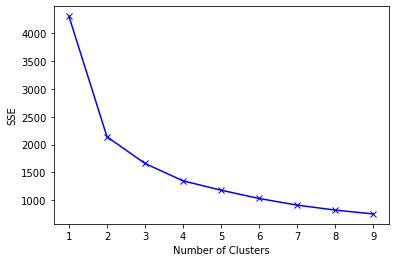

In [13]:
sse_val = []
for x in range(1, 10):
    kmeans = KMeans(n_clusters=x, init='k-means++', max_iter=100, random_state=42)
    kmeans=kmeans.fit(scaled_data)
    sse_val.append(kmeans.inertia_)


plt.plot(range(1, 10), sse_val, 'bx-')
plt.xticks(range(1, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [14]:
kl = KneeLocator(range(1, 10), sse_val, curve="convex", direction="decreasing")
kl.elbow

3

## Wykorzystanie k-means do grupowania klientów

In [15]:
kmeans_clusters = KMeans(n_clusters=3, init='k-means++', max_iter=100, random_state=42)
kmeans_clusters.fit(scaled_data)
df_bezOutlier['SegmentID'] = kmeans_clusters.labels_

In [16]:
colors = ['blue', 'orange', 'green']
df_bezOutlier['color'] = df_bezOutlier['SegmentID'].map(lambda x: colors[x])
df_bezOutlier

,level_0,index,CustomerId,Profit,Recency,Frequency,Monetary,Variance,r_score,f_score,m_score,RFM_group,RFM_group_name,RFM_score,SegmentID,color
0,0,0,1.0000,187.0000,63.0000,1.0000,2349.0601,2.0000,1,1,2,112,Hibernating,4,0,blue
1,1,1,2.0000,96.0000,10.0000,6.0000,922.6200,4.0000,3,2,1,321,Potential Loyalist,6,2,green
2,2,2,3.0000,47.0000,35.0000,4.0000,881.2200,3.0000,1,2,1,121,Hibernating,4,0,blue
3,3,3,4.0000,294.0000,5.0000,1.0000,3815.1599,2.0000,4,1,3,413,Potential Loyalist,8,2,green
4,4,4,5.0000,732.0000,4.0000,31.0000,41868.1094,29.0000,5,5,5,555,Champion,15,1,orange
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,1431,1506,1507.0000,174.0000,18.0000,3.0000,15798.9199,17.0000,2,1,4,214,Uncertain,7,2,green
1431,1432,1507,1508.0000,124.0000,28.0000,12.0000,2676.8899,7.0000,1,4,2,142,At Risk,7,2,green
1432,1433,1508,1509.0000,1543.0000,4.0000,17.0000,109497.5391,54.0000,5,5,5,555,Champion,15,1,orange
1433,1434,1509,1510.0000,668.0000,1.0000,3.0000,49602.4492,17.0000,5,1,5,515,Uncertain,11,1,orange


## Wykresy reprezentujace poszczególne grupy 

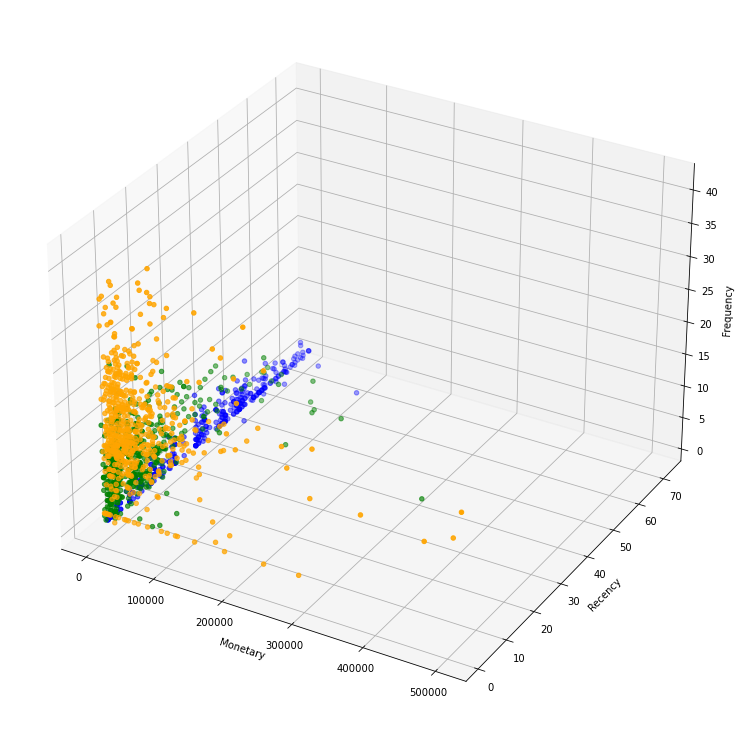

In [17]:
fig = pyplot.figure(figsize=(10,10))
ax = Axes3D(fig)
x_vals = list(df_bezOutlier['Monetary'])
y_vals = list(df_bezOutlier['Recency'])
z_vals = list(df_bezOutlier['Frequency'])
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')
ax.scatter(x_vals, y_vals, z_vals, c=df_bezOutlier['color'])

<AxesSubplot:xlabel='SegmentID', ylabel='Monetary'>

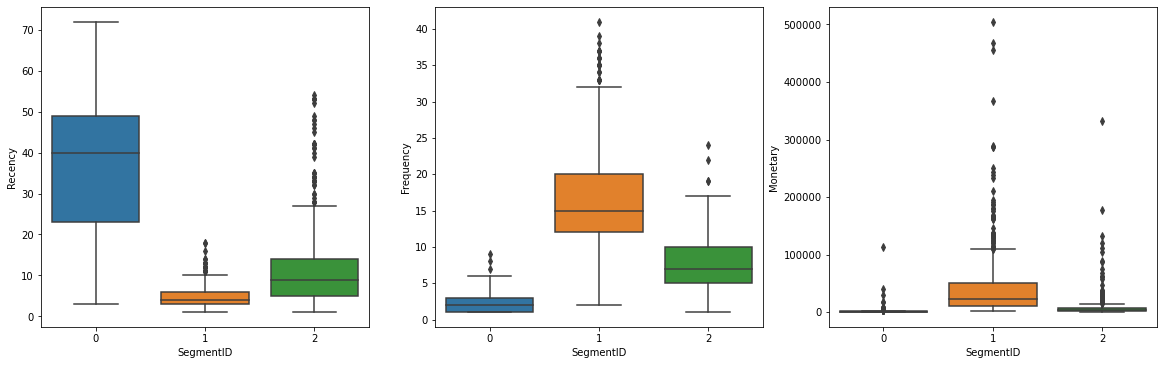

In [18]:
plt.figure(figsize=(20,20))
plt.subplot(3, 3, 1)
sns.boxplot(x=df_bezOutlier['SegmentID'], y=df_bezOutlier['Recency'])
plt.subplot(3, 3, 2)
sns.boxplot(x=df_bezOutlier['SegmentID'], y=df_bezOutlier['Frequency'])
plt.subplot(3, 3, 3)
sns.boxplot(x=df_bezOutlier['SegmentID'], y=df_bezOutlier['Monetary'])

## Końcowa tabela z nazwanymi grupami klientów: Złoto, Srebro i Brąz

In [19]:
ranks = ['brąz', 'złoto', 'srebro']
df_Final = df_bezOutlier.drop(['r_score', 'f_score', 'm_score', 'RFM_score', 'RFM_group', 'color'], axis=1).reset_index(drop=True)
df_Final['Segment_Name'] = df_bezOutlier['SegmentID'].map(lambda x: ranks[x])
df_Final = df_Final.drop(['level_0', 'index'], axis=1)
df_Final.to_csv('customersWynik.csv')
df_Final

,CustomerId,Profit,Recency,Frequency,Monetary,Variance,RFM_group_name,SegmentID,Segment_Name
0,1.0000,187.0000,63.0000,1.0000,2349.0601,2.0000,Hibernating,0,brąz
1,2.0000,96.0000,10.0000,6.0000,922.6200,4.0000,Potential Loyalist,2,srebro
2,3.0000,47.0000,35.0000,4.0000,881.2200,3.0000,Hibernating,0,brąz
3,4.0000,294.0000,5.0000,1.0000,3815.1599,2.0000,Potential Loyalist,2,srebro
4,5.0000,732.0000,4.0000,31.0000,41868.1094,29.0000,Champion,1,złoto
...,...,...,...,...,...,...,...,...,...
1430,1507.0000,174.0000,18.0000,3.0000,15798.9199,17.0000,Uncertain,2,srebro
1431,1508.0000,124.0000,28.0000,12.0000,2676.8899,7.0000,At Risk,2,srebro
1432,1509.0000,1543.0000,4.0000,17.0000,109497.5391,54.0000,Champion,1,złoto
1433,1510.0000,668.0000,1.0000,3.0000,49602.4492,17.0000,Uncertain,1,złoto
